In [47]:
!pip3 install hyperopt

     |████████████████████████████████| 972kB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 829kB 35.3MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491057 sha256=3b45313b4d59977b3c5189ec995c0d1c0394e7f9a43dacab7d1ed12704e37d3f
  Stored in directory: /Users/ayaanhaque/Library/Caches/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future


In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

import os

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
resumetable(df_train)

Dataset Shape: (856387, 28)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,RowId,int64,0,856387,1921357,1921358,1921359,19.71
1,IntersectionId,int64,0,2559,0,0,0,10.63
2,Latitude,float64,0,4799,33.7917,33.7917,33.7917,11.51
3,Longitude,float64,0,4804,-84.43,-84.43,-84.43,11.51
4,EntryStreetName,object,8148,1723,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest,9.04
5,ExitStreetName,object,6287,1703,Marietta Boulevard Northwest,Marietta Boulevard Northwest,Marietta Boulevard Northwest,9.02
6,EntryHeading,object,0,8,NW,SE,NW,2.84
7,ExitHeading,object,0,8,NW,SE,NW,2.84
8,Hour,int64,0,24,0,0,1,4.50
9,Weekend,int64,0,2,0,0,0,0.85


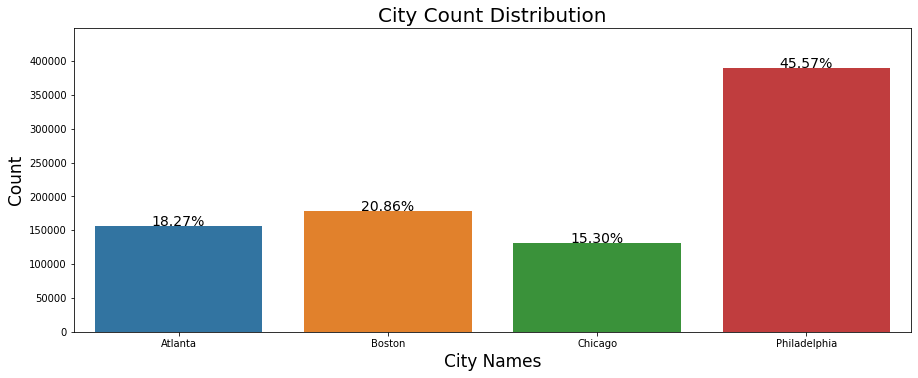

In [5]:
total = len(df_train)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="City", data=df_train)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("City Names", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()


In [6]:
tmp_hour = df_train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

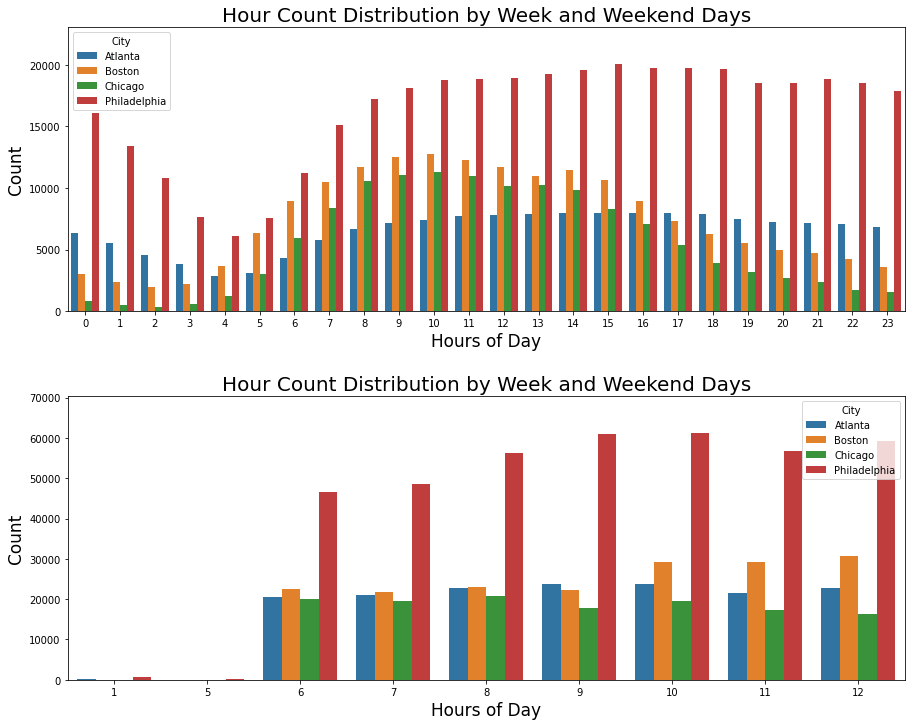

In [7]:
plt.figure(figsize=(15,12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=df_train, hue='City', dodge=True)
g.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="Month", data=df_train, hue='City', dodge=True)
g1.set_title("Hour Count Distribution by Week and Weekend Days", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

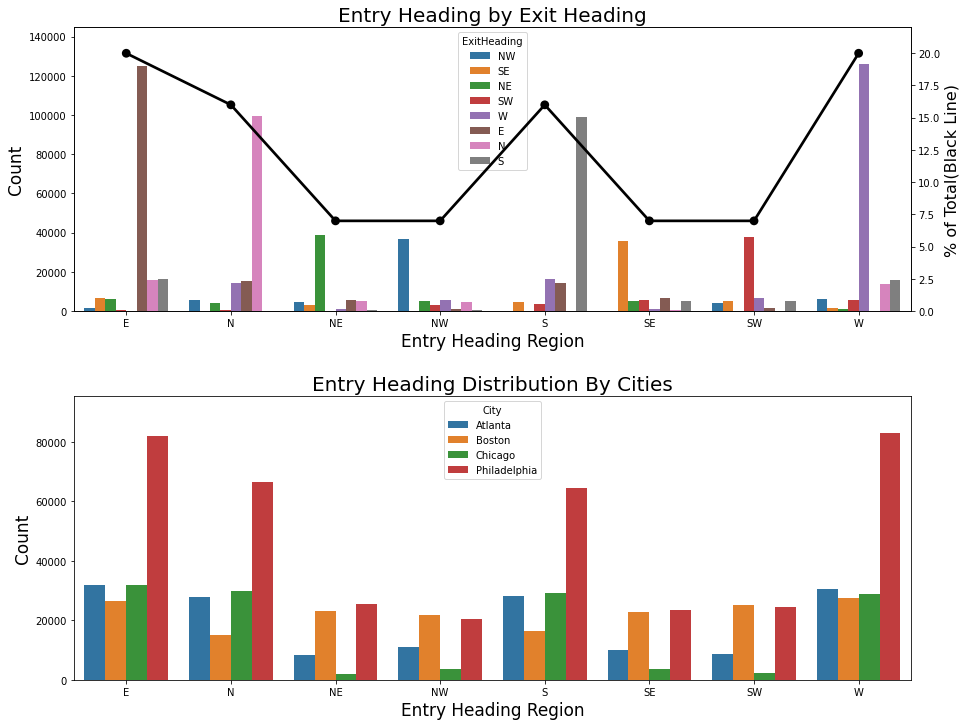

In [8]:
plt.figure(figsize=(15,12))

tmp = round(((df_train.groupby(['EntryHeading'])['RowId'].nunique() / total) * 100)).reset_index()

plt.subplot(211)
g = sns.countplot(x="EntryHeading",
                  data=df_train,
                  order=list(tmp['EntryHeading'].values),
                  hue='ExitHeading', dodge=True)
g.set_title("Entry Heading by Exit Heading", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Entry Heading Region", fontsize=17)
gt = g.twinx()
gt = sns.pointplot(x='EntryHeading', y='RowId', 
                   data=tmp, order=list(tmp['EntryHeading'].values),
                   color='black', legend=False)
gt.set_ylim(0, tmp['RowId'].max()*1.1)
gt.set_ylabel("% of Total(Black Line)", fontsize=16)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(212)
g1 = sns.countplot(x="EntryHeading", order=list(tmp['EntryHeading'].values), 
                   data=df_train, hue='City')
g1.set_title("Entry Heading Distribution By Cities", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Entry Heading Region", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

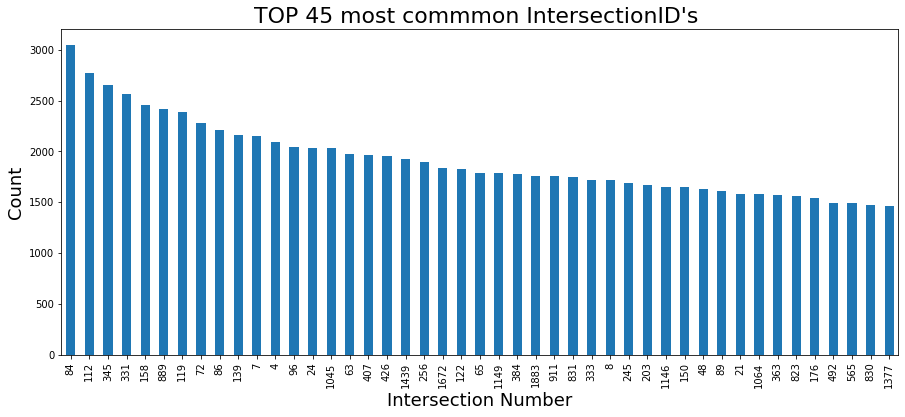

In [9]:
plt.figure(figsize=(15,6))
df_train.IntersectionId.value_counts()[:45].plot(kind='bar')
plt.xlabel("Intersection Number", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("TOP 45 most commmon IntersectionID's ", fontsize=22)

plt.show()

In [10]:
df_train.groupby(['IntersectionId', 'EntryHeading', 'ExitHeading'])['RowId'].count().reset_index().head()

,IntersectionId,EntryHeading,ExitHeading,RowId
0,0,E,E,128
1,0,E,N,23
2,0,E,NW,1
3,0,E,SW,3
4,0,N,E,34


In [11]:
t_stopped = ['TotalTimeStopped_p20',
             'TotalTimeStopped_p50', 
             'TotalTimeStopped_p80']
t_first_stopped = ['TimeFromFirstStop_p20',
                   'TimeFromFirstStop_p50',
                   'TimeFromFirstStop_p80']
d_first_stopped = ['DistanceToFirstStop_p20',
                   'DistanceToFirstStop_p50',
                   'DistanceToFirstStop_p80']

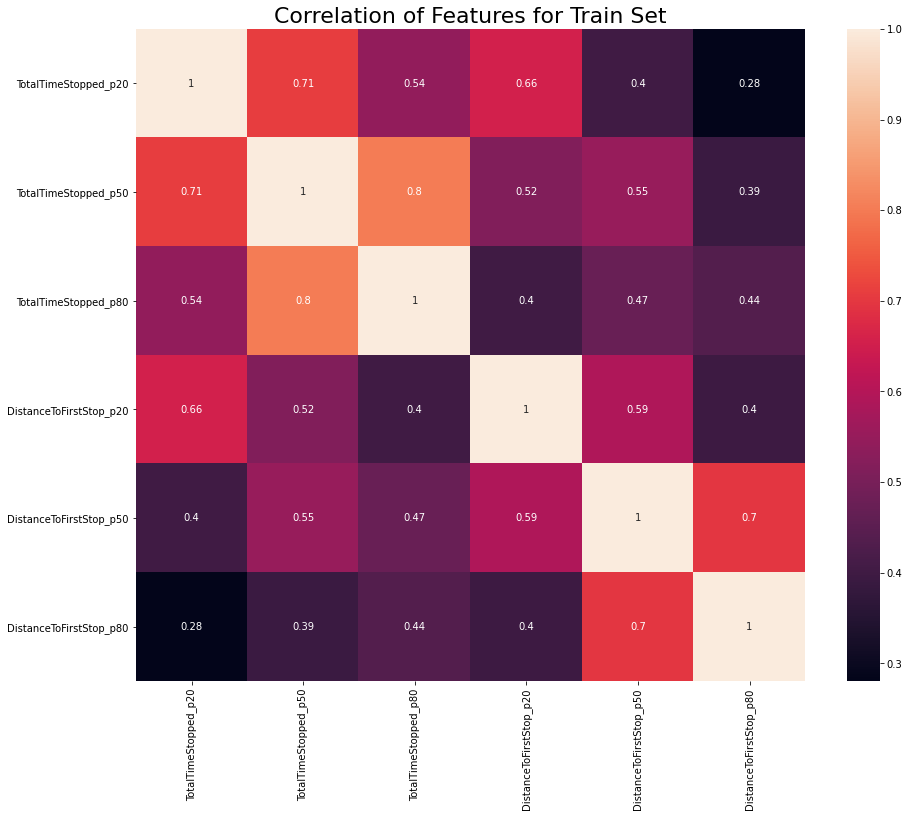

In [12]:
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set', fontsize=22)
sns.heatmap(df_train[t_stopped + 
                     #t_first_stopped + 
                     d_first_stopped].astype(float).corr(),
            vmax=1.0,  annot=True)
plt.show()

In [13]:
from sklearn.preprocessing import minmax_scale

target_cols = t_stopped + d_first_stopped

In [14]:
for col in target_cols:
    df_train[col+str("_minmax")] = (minmax_scale(df_train[col], feature_range=(0,1)))
    
min_max_cols = ['TotalTimeStopped_p20_minmax', 'TotalTimeStopped_p50_minmax',
                'TotalTimeStopped_p80_minmax', 'DistanceToFirstStop_p20_minmax',
                'DistanceToFirstStop_p50_minmax', 'DistanceToFirstStop_p80_minmax']


In [15]:
pca = PCA(n_components=3, random_state=5)

principalComponents = pca.fit_transform(df_train[min_max_cols])

principalDf = pd.DataFrame(principalComponents)

# df.drop(cols, axis=1, inplace=True)
prefix='Target_PCA'
principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

df_train = pd.concat([df_train, principalDf], axis=1)


In [16]:
pca.explained_variance_ratio_[:2].sum()

0.8388302642985757

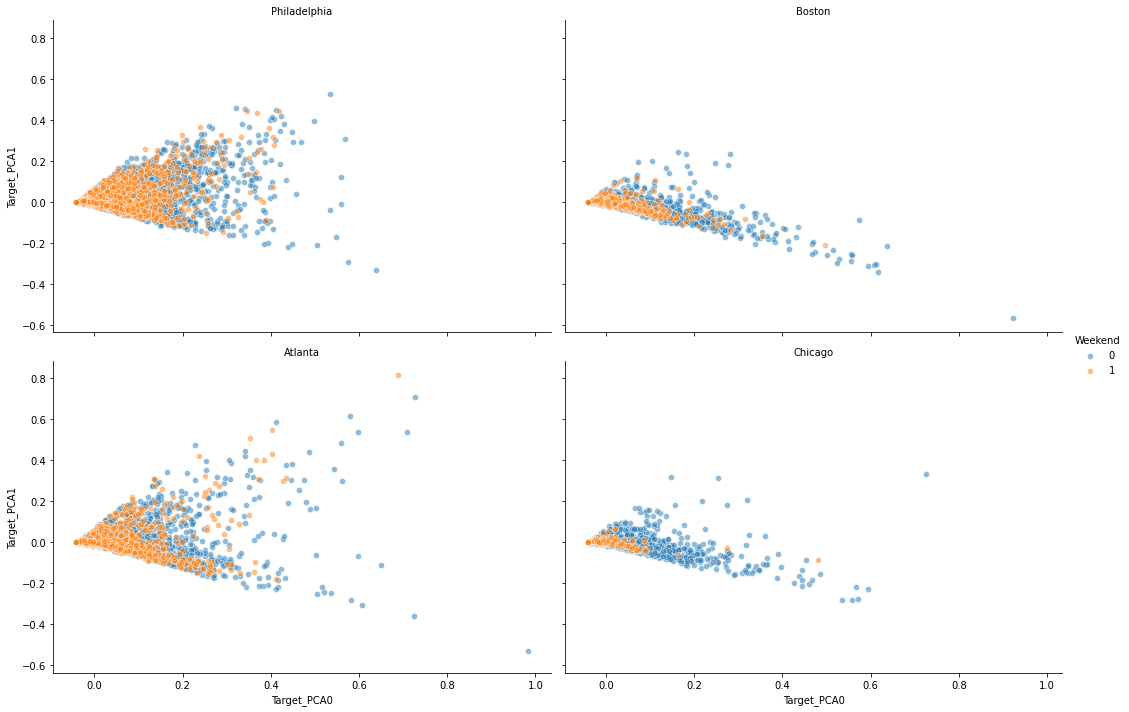

In [17]:
g = sns.FacetGrid(df_train.sample(50000), col="City", 
                  col_wrap=2, height=5, aspect=1.5, hue='Weekend')

g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", alpha=.5 ).add_legend();
g.set_titles('{col_name}', fontsize=17)
plt.show()

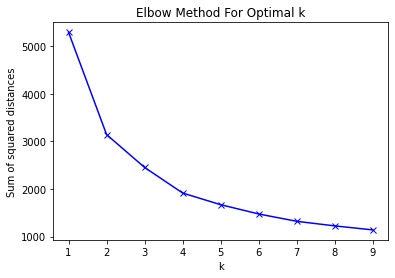

In [18]:
#sum of squared distances
ssd = []

K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=4)
    km = km.fit(df_train[min_max_cols])
    ssd.append(km.inertia_)
    
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.show()

In [19]:
km = KMeans(n_clusters=4, random_state=4)
km = km.fit(df_train[min_max_cols])
df_train['clusters_T'] = km.predict(df_train[min_max_cols])

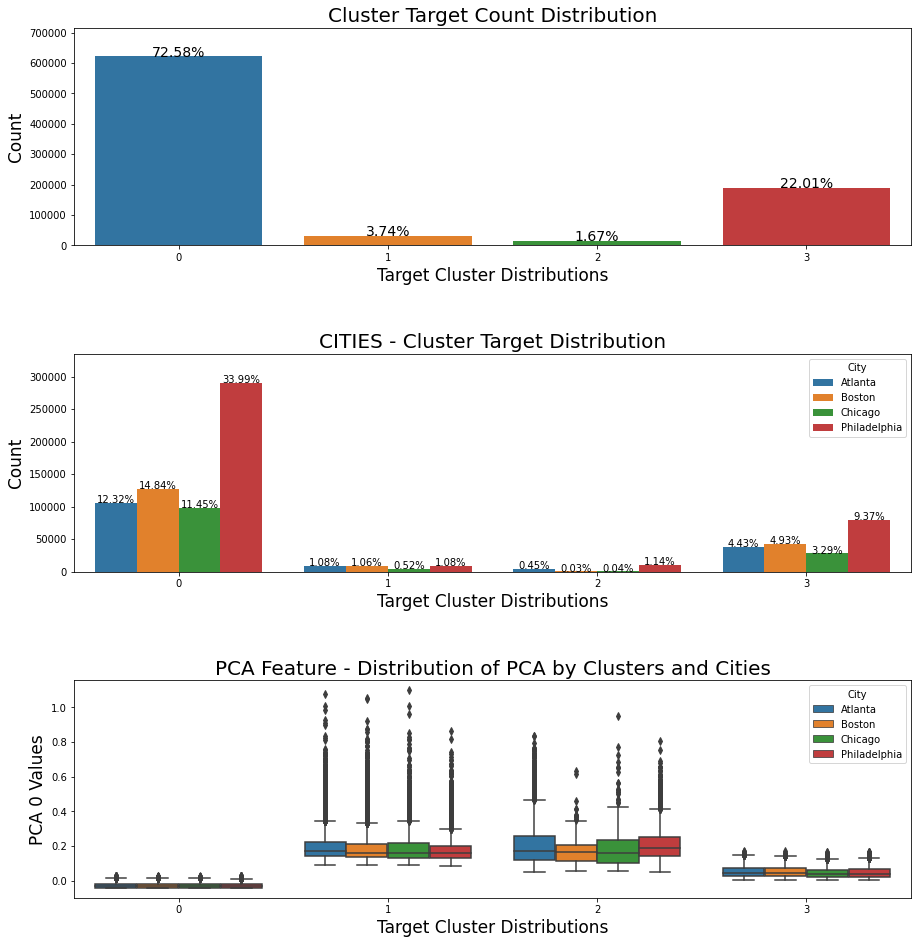

In [20]:
tmp = pd.crosstab(df_train['City'], df_train['clusters_T'], 
                  normalize='columns').unstack('City').reset_index().rename(columns={0:"perc"})

total = len(df_train)
plt.figure(figsize=(15,16))

plt.subplot(311)
g = sns.countplot(x="clusters_T", data=df_train)
g.set_title("Cluster Target Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.subplot(312)
g1 = sns.countplot(x="clusters_T", data=df_train, hue='City')
g1.set_title("CITIES - Cluster Target Distribution", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=10)
g1.set_ylim(0, max(sizes) * 1.15)

plt.subplot(313)
g1 = sns.boxplot(x="clusters_T", y='Target_PCA0', 
                 data=df_train, hue='City')
g1.set_title("PCA Feature - Distribution of PCA by Clusters and Cities", 
             fontsize=20)
g1.set_ylabel("PCA 0 Values",fontsize= 17)
g1.set_xlabel("Target Cluster Distributions", fontsize=17)

plt.subplots_adjust(hspace = 0.5)

plt.show()

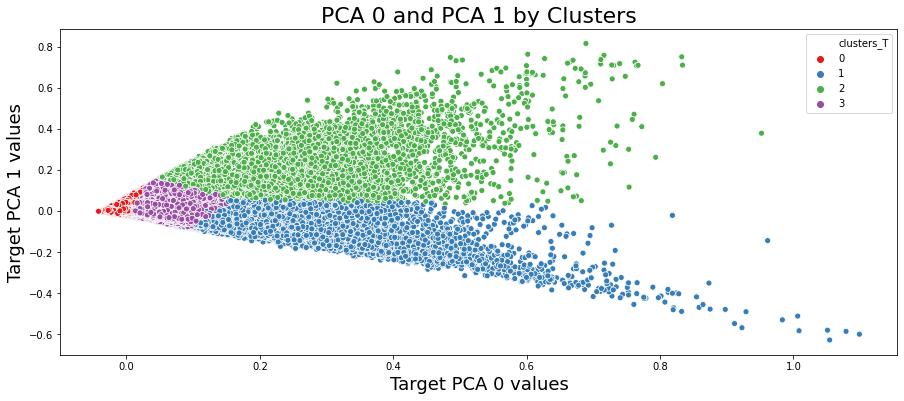

In [21]:
plt.figure(figsize=(15,6))

sns.scatterplot(x='Target_PCA0', y='Target_PCA1',
                hue='clusters_T', data=df_train,
                palette='Set1')
plt.title("PCA 0 and PCA 1 by Clusters", fontsize=22)
plt.ylabel("Target PCA 1 values", fontsize=18)
plt.xlabel("Target PCA 0 values", fontsize=18)

plt.show()


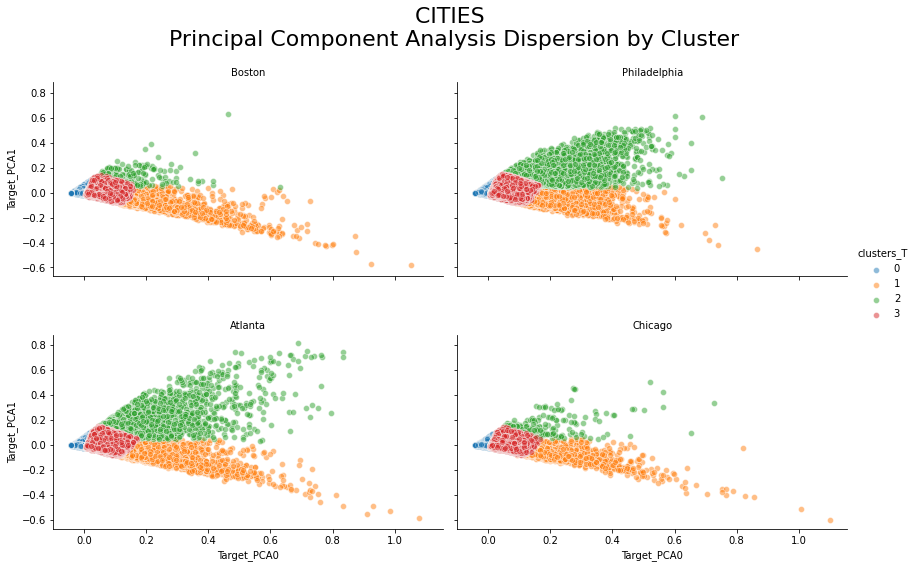

In [22]:
g = sns.FacetGrid(df_train.sample(500000), col="City", 
                  col_wrap=2, height=4, aspect=1.5, 
                  hue='clusters_T')

g.map(sns.scatterplot, "Target_PCA0", "Target_PCA1", 
      alpha=.5).add_legend();
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by Cluster", fontsize=22)

plt.subplots_adjust(hspace = 0.3, top=.85)

plt.show()

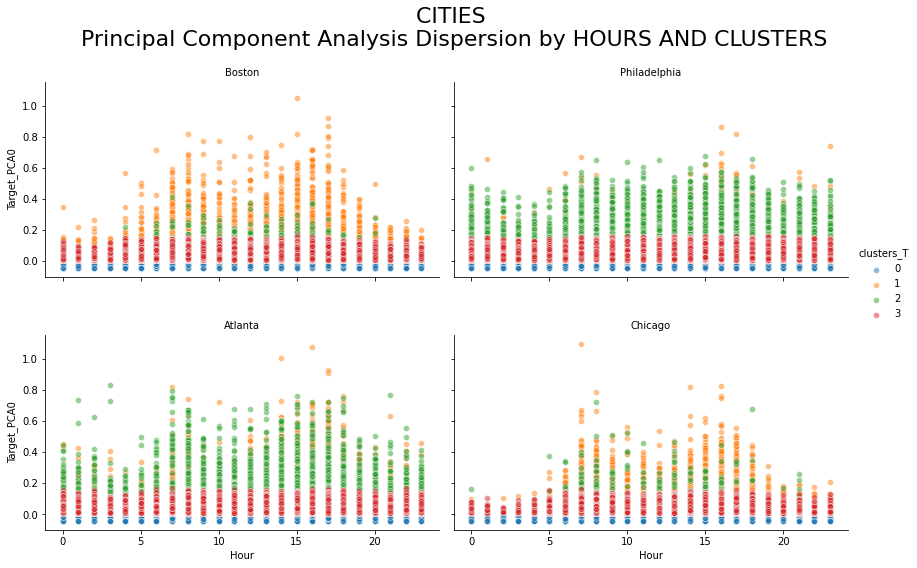

In [23]:
g = sns.FacetGrid(df_train.sample(500000), col="City", 
                  col_wrap=2, height=4, aspect=1.5, 
                  hue='clusters_T')

g.map(sns.scatterplot, "Hour", "Target_PCA0", 
      alpha=.5).add_legend();
g.set_titles('{col_name}', fontsize=50)

plt.suptitle("CITIES \nPrincipal Component Analysis Dispersion by HOURS AND CLUSTERS", fontsize=22)

plt.subplots_adjust(hspace = 0.3, top=.85)

plt.show()

In [24]:
round(pd.crosstab([df_train['clusters_T'], df_train['Weekend']], df_train['City'],
            normalize='index' ) * 100,0)

City                Atlanta  Boston  Chicago  Philadelphia
clusters_T Weekend                                        
0          0           15.0    22.0     21.0          42.0
           1           22.0    16.0      3.0          59.0
1          0           27.0    31.0     16.0          26.0
           1           41.0    15.0      2.0          42.0
2          0           26.0     3.0      4.0          68.0
           1           30.0     1.0      0.0          69.0
3          0           18.0    25.0     19.0          39.0
           1           29.0    14.0      2.0          56.0

In [25]:
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

df_train = date_cyc_enc(df_train, 'Hour', 24)
df_test = date_cyc_enc(df_test, 'Hour', 24) 

In [26]:
df_train['is_day'] = df_train['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)
df_test['is_day'] = df_test['Hour'].apply(lambda x: 1 if 7 < x < 18 else 0)

df_train['is_morning'] = df_train['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)
df_test['is_morning'] = df_test['Hour'].apply(lambda x: 1 if 6 < x < 10 else 0)

df_train['is_night'] = df_train['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)
df_test['is_night'] = df_test['Hour'].apply(lambda x: 1 if 17 < x < 20 else 0)

df_train['is_day_weekend'] = np.where((df_train['is_day'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_day_weekend'] = np.where((df_test['is_day'] == 1) & (df_train['Weekend'] == 1), 1,0)

df_train['is_mor_weekend'] = np.where((df_train['is_morning'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_mor_weekend'] = np.where((df_test['is_morning'] == 1) & (df_train['Weekend'] == 1), 1,0)

df_train['is_nig_weekend'] = np.where((df_train['is_night'] == 1) & (df_train['Weekend'] == 1), 1,0)
df_test['is_nig_weekend'] = np.where((df_test['is_night'] == 1) & (df_train['Weekend'] == 1), 1,0)
 

In [27]:
df_train["Intersec"] = df_train["IntersectionId"].astype(str) + df_train["City"]
df_test["Intersec"] = df_test["IntersectionId"].astype(str) + df_test["City"]

print(df_train["Intersec"].sample(6).values)

['93Atlanta' '158Atlanta' '1495Chicago' '497Atlanta' '717Philadelphia'
 '106Philadelphia']


In [28]:
le = LabelEncoder()

le.fit(pd.concat([df_train["Intersec"],df_test["Intersec"]]).drop_duplicates().values)
df_train["Intersec"] = le.transform(df_train["Intersec"])
df_test["Intersec"] = le.transform(df_test["Intersec"])

In [29]:
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

In [30]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
    return 0

In [31]:
df_train['EntryType'] = df_train['EntryStreetName'].apply(encode)
df_train['ExitType'] = df_train['ExitStreetName'].apply(encode)
df_test['EntryType'] = df_test['EntryStreetName'].apply(encode)
df_test['ExitType'] = df_test['ExitStreetName'].apply(encode)


In [32]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

In [33]:
df_train['EntryHeading'] = df_train['EntryHeading'].map(directions)
df_train['ExitHeading'] = df_train['ExitHeading'].map(directions)

df_test['EntryHeading'] = df_test['EntryHeading'].map(directions)
df_test['ExitHeading'] = df_test['ExitHeading'].map(directions)

In [34]:
df_train['diffHeading'] = df_train['EntryHeading']-df_train['ExitHeading']  
df_test['diffHeading'] = df_test['EntryHeading']-df_test['ExitHeading']

In [35]:
df_train["same_str"] = (df_train["EntryStreetName"] ==  df_train["ExitStreetName"]).astype(int)
df_test["same_str"] = (df_test["EntryStreetName"] ==  df_test["ExitStreetName"]).astype(int)

In [36]:
# Concatenating the city and month into one variable
df_train['city_month'] = df_train["City"] + df_train["Month"].astype(str)
df_test['city_month'] = df_test["City"] + df_test["Month"].astype(str)


In [37]:
monthly_rainfall = {'Atlanta1': 5.02, 'Atlanta5': 3.95, 'Atlanta6': 3.63, 'Atlanta7': 5.12, 
                    'Atlanta8': 3.67, 'Atlanta9': 4.09,'Atlanta10': 3.11, 'Atlanta11': 4.10, 
                    'Atlanta12': 3.82, 'Boston1': 3.92, 'Boston5': 3.24, 'Boston6': 3.22,
                    'Boston7': 3.06, 'Boston8': 3.37, 'Boston9': 3.47, 'Boston10': 3.79,
                    'Boston11': 3.98, 'Boston12': 3.73, 'Chicago1': 1.75, 'Chicago5': 3.38,
                    'Chicago6': 3.63, 'Chicago7': 3.51, 'Chicago8': 4.62, 'Chicago9': 3.27,
                    'Chicago10': 2.71,  'Chicago11': 3.01, 'Chicago12': 2.43, 
                    'Philadelphia1': 3.52, 'Philadelphia5': 3.88, 'Philadelphia6': 3.29,
                    'Philadelphia7': 4.39, 'Philadelphia8': 3.82, 'Philadelphia9':3.88 ,
                    'Philadelphia10': 2.75, 'Philadelphia11': 3.16, 'Philadelphia12': 3.31}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
df_train["average_rainfall"] = df_train['city_month'].map(monthly_rainfall)
df_test["average_rainfall"] = df_test['city_month'].map(monthly_rainfall)

In [38]:
print(f'Shape before dummy transformation: {df_train.shape}')
df_train = pd.get_dummies(df_train, columns=['City' ],\
                          prefix=['City'], drop_first=False)

print(f'Shape after dummy transformation: {df_train.shape}')

df_test = pd.get_dummies(df_test, columns=['City' ],\
                          prefix=['City'], drop_first=False)


Shape before dummy transformation: (856387, 53)
Shape after dummy transformation: (856387, 56)


In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in ['Latitude','Longitude']:
    scaler.fit(df_train[col].values.reshape(-1, 1))
    df_train[col] = scaler.transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = scaler.transform(df_test[col].values.reshape(-1, 1))

In [40]:
df_train.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'
              ],axis=1, inplace=True)
df_test.drop(['RowId', 'Path',
              'EntryStreetName','ExitStreetName'],axis=1, inplace=True)

In [41]:
interesting_feat = ['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
                    'ExitHeading', 'Hour', 'Weekend', 'Month',
                    'is_morning', 'is_night', 'is_day_weekend', 'is_mor_weekend',
                    'is_nig_weekend', #  'Hour_sin',
                    'Hour', 'same_str', 'Intersec', 'EntryType',
                    'ExitType', 'diffHeading', 'average_rainfall', 'is_day',
                    'City_Boston', 'City_Chicago', 'City_Philadelphia', 
                    'City_Atlanta']

total_time = ['TotalTimeStopped_p20',
              'TotalTimeStopped_p50', 
              'TotalTimeStopped_p80']

target_stopped = ['DistanceToFirstStop_p20',
                  'DistanceToFirstStop_p50',
                  'DistanceToFirstStop_p80']

In [42]:
X = df_train[interesting_feat]
y = df_train[total_time + target_stopped]

X_test = df_test[interesting_feat]

In [43]:
print(f'Shape of X: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X: (856387, 25)
Shape of X_test: (1921357, 25)


In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,
                                                  random_state=42)

In [49]:
# Define searched space
hyper_space = {'objective': 'regression',
               'metric':'rmse',
               'boosting':'gbdt', 'gpu_device_id': 0,
               #'n_estimators': hp.choice('n_estimators', [25, 40, 50, 75, 100, 250, 500]),
               'max_depth':  hp.choice('max_depth', list(range(6, 18, 2))),
               'num_leaves': hp.choice('num_leaves', list(range(20, 180, 20))),
               'subsample': hp.choice('subsample', [.7, .8, .9, 1]),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
               'learning_rate': hp.uniform('learning_rate', 0.03, 0.12),
               #'reg_alpha': hp.choice('reg_alpha', [.1, .2, .3, .4, .5, .6]),
               #'reg_lambda':  hp.choice('reg_lambda', [.1, .2, .3, .4, .5, .6]),               
               'min_child_samples': hp.choice('min_child_samples', [20, 45, 70, 100])}

In [50]:
cat_feat = ['IntersectionId','Hour', 'Weekend','Month', 
            'is_day', 'is_morning', 'is_night', 
            'same_str', 'Intersec', 'City_Atlanta', 'City_Boston',
            'City_Chicago', 'City_Philadelphia', 'EntryType', 'ExitType']

In [52]:
!pip3 install lightgbm

     |████████████████████████████████| 1.0MB 2.2MB/s eta 0:00:01


In [53]:
from sklearn.model_selection import KFold
import lightgbm as lgb

def evaluate_metric(params):
    
    all_preds_test ={0:[],1:[],2:[],3:[],4:[],5:[]}
    
    print(f'Params: {params}')
    FOLDS = 4    
    
    count=1
    
    for i in range(len(all_preds_test)):
        
        score_mean = 0
        
        kf = KFold(n_splits=FOLDS, shuffle=False, 
                   random_state=42)
        
       
        for tr_idx, val_idx in kf.split(X, y):
            
            X_tr, X_vl = X.iloc[tr_idx, :], X.iloc[val_idx, :]
            y_tr, y_vl = y.iloc[tr_idx], y.iloc[val_idx]

            lgtrain = lgb.Dataset(X_tr, label=y_tr.iloc[:,i])
            lgval = lgb.Dataset(X_vl, label=y_vl.iloc[:,i])

            lgbm_reg = lgb.train(params, lgtrain, 2000, valid_sets = [lgval],
                                 categorical_feature=cat_feat,
                                 verbose_eval=0, 
                                 early_stopping_rounds = 300)
                        
        pred_lgb = lgbm_reg.predict(X_val, num_iteration=lgbm_reg.best_iteration)
        all_preds_test[i] = pred_lgb
        score_uni = np.sqrt(mean_squared_error(pred_lgb, y_val.iloc[:,i]))
        print(f'Score Validation : {score_uni}')


    pred = pd.DataFrame(all_preds_test).stack()
    pred = pd.DataFrame(pred)
    
    y_val_sc = pd.DataFrame(y_val).stack()
    y_val_sc = pd.DataFrame(y_val_sc)    
    
    count = count +1
    
    score = np.sqrt(mean_squared_error(pred[0].values, y_val_sc[0].values ))
    #score = metric(df_val, pred)
    
    print(f'Full Score Run: {score}')
 
    return {
        'loss': score,
        'status': STATUS_OK
    }
